In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import as_functions as asf

sns.set_context('talk')
sns.set_style('darkgrid')
NUM_WEEKS = 181
np.random.seed(23935879)

## Reading From CSV

In [2]:
df = pd.read_csv("Crashes_in_DC.csv")

/Users/anthonyschams/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.REPORTDATE = pd.to_datetime(df.REPORTDATE)
df.FROMDATE = pd.to_datetime(df.FROMDATE)
df.TODATE = pd.to_datetime(df.TODATE)
df["report_second"] = df.REPORTDATE.apply(lambda date: date.second)
df["report_minute"] = df.REPORTDATE.apply(lambda date: date.minute)
df["report_hour"] = df.REPORTDATE.apply(lambda date: date.hour)
df['report_day'] = df.REPORTDATE.apply(lambda date: date.day)
df["report_month"] = df.REPORTDATE.apply(lambda date: date.month)
df["report_year"] = df.REPORTDATE.apply(lambda date: date.year)
df["report_day_of_week"] = df.REPORTDATE.apply(lambda date: date.dayofweek)
df["quadrant"] = df.ADDRESS.str.extract(r" ([NS][WE])\b")
df["ward"] = df.WARD.str.extract(r"([1-8])")

## Exploring the Data a bit

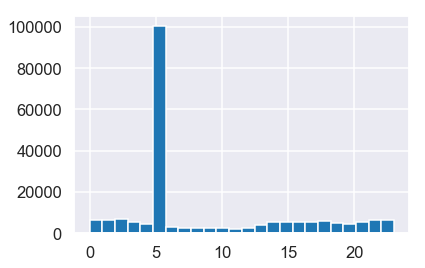

In [4]:
df.report_hour.hist(bins=24)

An abnormal number of crashes are reported at exactly 5 am. This appears to be the fill value if a crash's time is not properly recorded. We will therefore drop these data.

In [5]:
df_except_5_oclock = df[~((df.report_hour == 5) & (df.report_minute == 0) & (df.report_second == 0))]

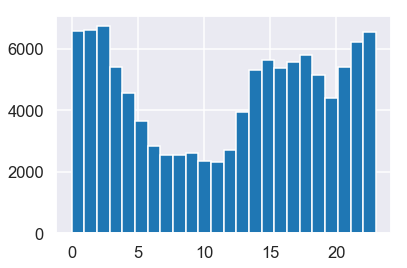

In [6]:
df_except_5_oclock.report_hour.hist(bins=24)

This is much more reasonable.

In [7]:
df_except_5_oclock.report_year.value_counts()

2016.0    26548
2017.0    26446
2018.0    26363
2019.0    11926
2015.0    10235
2012.0     5518
2014.0     1582
2013.0     1173
2011.0      566
2009.0      250
2010.0      205
2008.0       77
2006.0       16
2005.0       13
2007.0       12
2000.0       10
1998.0        6
1990.0        4
1989.0        4
2002.0        3
1997.0        3
1992.0        3
2003.0        3
2001.0        2
1996.0        2
1991.0        2
1999.0        1
1995.0        1
1994.0        1
1993.0        1
2004.0        1
Name: report_year, dtype: int64

When we remove our unusual 5 am reports, we see that 2016-2019 are the only years that appear to be 'complete.' 2015 has a low number of crashes relative to 2016, so we believe that many of the 2015 reports were recorded with times of 5 am and were dropped. Because of the data on 2015 crashes is so incomplete, we will limir our analysis to the years 2016-2019.

In [8]:
df2 = df_except_5_oclock[(df_except_5_oclock.report_year > 2015) & (df_except_5_oclock.report_year < 2020)].copy()
day_of_week = {0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}

In [9]:
df2['time_of_day'] = df2.report_hour.apply(asf.get_time_of_day)
early_morning = df2[(df2.time_of_day == 'Early_Morning')]
rush_hour_morn = df2[df2.time_of_day == 'Rush_Hour_Morning']
day = df2[df2.time_of_day == 'Day']
rush_hour_evening = df2[df2.time_of_day == 'Rush_Hour_Evening']
night = df2[df2.time_of_day == 'Night']

In [10]:
x = pd.Series(df2.groupby(['report_day_of_week',
                           'report_year', 
                           'report_month', 
                           'report_day']).count()['X'])

In [11]:
monday = x.xs(0).values
tuesday = x.xs(1).values
wednesday = x.xs(2).values
thursday = x.xs(3).values
friday = x.xs(4).values
saturday = x.xs(5).values
sunday = x.xs(6).values

monday_padded = asf.pad_array(monday, NUM_WEEKS)
tuesday_padded = asf.pad_array(tuesday, NUM_WEEKS)
wednesday_padded = asf.pad_array(wednesday, NUM_WEEKS)
thursday_padded = asf.pad_array(thursday, NUM_WEEKS)
friday_padded = asf.pad_array(friday, NUM_WEEKS)
saturday_padded = asf.pad_array(saturday, NUM_WEEKS)
sunday_padded = asf.pad_array(sunday, NUM_WEEKS)

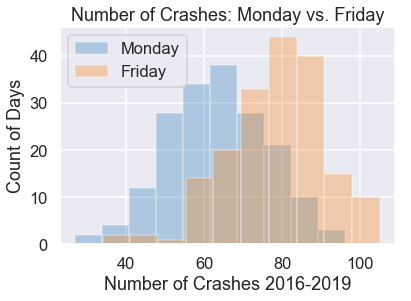

In [12]:
plt.hist(monday, alpha = 0.3, label='Monday')
plt.hist(friday, alpha=0.3, label='Friday')
plt.xlabel('Number of Crashes 2016-2019')
plt.ylabel('Count of Days')
plt.title('Number of Crashes: Monday vs. Friday')
plt.legend()

These two curves look roughly normally distributed, so we will use a t-test to compare their means.

In [13]:
print(f'T-test: Number of Crashes - Monday vs. Friday: {stats.ttest_ind(monday, friday, equal_var=False)}')

T-test: Number of Crashes - Monday vs. Friday: Ttest_indResult(statistic=-11.595941986328668, pvalue=1.3227792675993172e-26)


We see that this test has a very low p-value, so we reject the null hypothesis that the number of crashes on Friday and Monday are the same.

## Monday vs. Friday (Time of Day)

We would also like to compare how time of day affects the number of crashes on Monday vs. Friday. Perhaps the number of crashes Friday is due to more people going out on Friday nights. We will be looking at commute times between the two days.

In [14]:
y = pd.Series(df2.groupby(['time_of_day',
                           'report_day_of_week',
                           'report_year', 
                           'report_month', 
                           'report_day']).count()['X'])

In [15]:
monday_morn = y.xs('Rush_Hour_Morning').xs(0).values
tuesday_morn =  y.xs('Rush_Hour_Morning').xs(1).values
wednesday_morn =  y.xs('Rush_Hour_Morning').xs(2).values
thursday_morn =  y.xs('Rush_Hour_Morning').xs(3).values
friday_morn =  y.xs('Rush_Hour_Morning').xs(4).values
saturday_morn =  y.xs('Rush_Hour_Morning').xs(5).values
sunday_morn =  y.xs('Rush_Hour_Morning').xs(6).values

monday_rh_evening = y.xs('Rush_Hour_evening').xs(0).values
tuesday_rh_evening = y.xs('Rush_Hour_evening').xs(1).values
wednesday_rh_evening = y.xs('Rush_Hour_evening').xs(2).values
thursday_rh_evening = y.xs('Rush_Hour_evening').xs(3).values
friday_rh_evening = y.xs('Rush_Hour_evening').xs(4).values


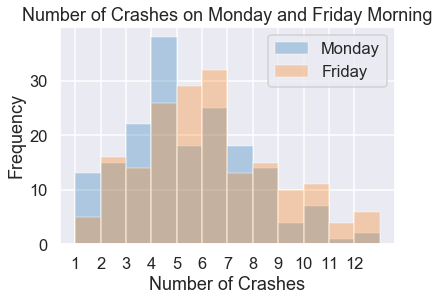

In [16]:
_ = plt.hist(monday_morn, bins=12, alpha=0.3, label="Monday")
_ = plt.hist(friday_morn, bins=12, alpha=0.3, label='Friday')
_ = plt.xticks(range(1, 13, 1))
_ = plt.title("Number of Crashes on Monday and Friday Morning")
_ = plt.ylabel('Frequency')
_ = plt.xlabel('Number of Crashes')
_ = plt.legend()

## Permutation Test for Monday Morning vs. Friday Morning

Because the distribution of number of crashes on Monday morning is not normally distributed, we will instead use a permutation test. Our null hypothesis is that # of crashes on Monday morning is the same as the number of crashes on Friday morning. (The difference in # of crashes is 0.) Monday and Friday are of specific interest to us because of the differing attitudes towards each day. Monday is the start of the week following a weekend, while Friday is the end of the week, where we expect people to be excited for the weekend. 

In [17]:
monday_morn_padded = asf.pad_array(monday_morn, NUM_WEEKS)
friday_morn_padded = asf.pad_array(friday_morn, NUM_WEEKS)

In [18]:
asf.permutation_test(monday_morn_padded, friday_morn_padded, 100000)

0.00042

The associated p-value is small, so we will reject the null hypothesis that the number of crashes in the morning of the two days are the same. This indicates to us that Monday morning has significantly fewer crashes than Friday morning. This could be a result of the people being well rested over the weekend and fatigued at the end of the week, or perhaps people are excited for the weekend and are less careful drivers.

In [19]:
monday_rh_evening_padded = asf.pad_array(monday_rh_evening, NUM_WEEKS)
tuesday_rh_evening_padded = asf.pad_array(tuesday_rh_evening, NUM_WEEKS)
wednesday_rh_evening_padded = asf.pad_array(wednesday_rh_evening, NUM_WEEKS)
thursday_rh_evening_padded = asf.pad_array(thursday_rh_evening, NUM_WEEKS)
friday_rh_evening_padded = asf.pad_array(friday_rh_evening, NUM_WEEKS)

In [20]:
asf.permutation_test(monday_rh_evening_padded, friday_rh_evening_padded, 100000)

0.00075

Looking at evening rush hour, we see a similar pattern: Friday has more crashes than Monday. This again could be fatigue at the end of the week, as well as perhaps people's excitement to get home negatively impacts their driving.

In [21]:
print(f"Permutation Test - Monday vs. Friday Evening: {asf.permutation_test(monday_rh_evening_padded, friday_rh_evening_padded, 100000)}")
print(f"Permutation Test - Tuesday vs. Friday Evening: {asf.permutation_test(tuesday_rh_evening_padded, friday_rh_evening_padded, 100000)}")
print(f"Permutation Test - Wednesday vs. Friday Evening: {asf.permutation_test(wednesday_rh_evening_padded, friday_rh_evening_padded, 100000)}")
print(f"Permutation Test - Thursday vs. Friday Evening: {asf.permutation_test(thursday_rh_evening_padded, friday_rh_evening_padded, 100000)}")

      
      

Permutation Test - Monday vs. Friday Evening: 0.00075
Permutation Test - Tuesday vs. Friday Evening: 0.00022
Permutation Test - Wednesday vs. Friday Evening: 0.01913
Permutation Test - Thursday vs. Friday Evening: 0.01106


Because we have performed multiple tests, we must include an adjustment to the p-value to be more confident we are not making a type-I error. Because we have made 4 comaparisons, we make a Sidak adjustment to
$\alpha_{new} = 1 - (1-\alpha_0)^{1/4} = 1 - (0.95)^{1/4} = 0.0127$. 
At this significance level, it appears that only Wednesday is not significantly different with respect to the number of crashes during evening rush hour. This is interesting to us, as there is no intuitive reason that Wednesday would have as many crashes as Friday. 

## Weekdays vs. weekends
Looking at whether more crashes occur on weekdays or weekends.

In [22]:
weekend = np.append(saturday_padded, sunday_padded)
weekdays = np.append(monday_padded, [tuesday_padded, wednesday_padded, thursday_padded, friday_padded])

In [23]:
asf.permutation_test(weekdays, weekend, 100000)

0.0

In [24]:
asf.permutation_test(saturday_padded, friday_padded, 100000)

0.01372

## Pedestrian Safety

In [25]:
z = df2.groupby(['time_of_day',
                 'report_day_of_week',
                 'report_year', 
                 'report_month', 
                 'report_day']).sum().TOTAL_PEDESTRIANS

In [26]:
peds_monday_morn = z.xs('Rush_Hour_Morning').xs(0).values
peds_tuesday_morn =  z.xs('Rush_Hour_Morning').xs(1).values
peds_wednesday_morn =  z.xs('Rush_Hour_Morning').xs(2).values
peds_thursday_morn =  z.xs('Rush_Hour_Morning').xs(3).values
peds_friday_morn =  z.xs('Rush_Hour_Morning').xs(4).values
peds_saturday_morn =  z.xs('Rush_Hour_Morning').xs(5).values
peds_sunday_morn =  z.xs('Rush_Hour_Morning').xs(6).values

peds_monday_rh_evening = z.xs('Rush_Hour_evening').xs(0).values
peds_tuesday_rh_evening = z.xs('Rush_Hour_evening').xs(1).values
peds_wednesday_rh_evening = z.xs('Rush_Hour_evening').xs(2).values
peds_thursday_rh_evening = z.xs('Rush_Hour_evening').xs(3).values
peds_friday_rh_evening = z.xs('Rush_Hour_evening').xs(4).values

In [27]:
peds_morning_commute = np.concatenate((peds_monday_morn,
                                       peds_tuesday_morn,
                                       peds_wednesday_morn,
                                       peds_thursday_morn, 
                                       peds_friday_morn))

peds_evening_commute = np.concatenate((peds_monday_rh_evening, 
                                  peds_tuesday_rh_evening, 
                                  peds_wednesday_rh_evening, 
                                  peds_thursday_rh_evening, 
                                  peds_friday_rh_evening))



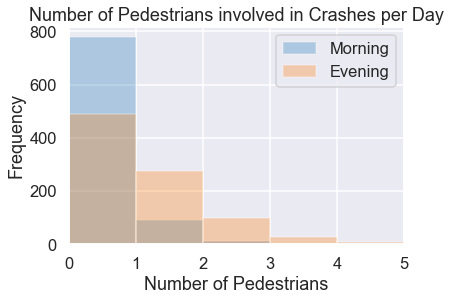

In [28]:
plt.hist(peds_morning_commute, bins=12, alpha=0.3, label="Morning")
plt.hist(peds_evening_commute, bins=5, alpha=0.3, label='Evening')
plt.xlim([0, 5])
plt.title("Number of Pedestrians involved in Crashes per Day")
plt.xlabel("Number of Pedestrians")
plt.ylabel("Frequency")
plt.legend()

In [29]:
asf.permutation_test(peds_morning_commute, peds_evening_commute, 100000)

0.0